

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## PGE 383 Graduate Student Project Template 


## Impact of learning rate on the robustness of gradient boosting

#### Chuxi Liu
#### The Hildebrand Department of Petroleum and Geosystems Engineering, University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)

#### Disclaimer:

Majority of preprocessing steps of this workflow is based on many workflows' preprocessing procedures provided by Dr. Michael Pyrcz (PGE 383 Subsurface Machine Learning Course Material)


### Executive Summary

The goal of this workflow is to demonstrate how will effects of different loss function and problem settings will affect the optimization of learning rate on the gradient boosting model. In this workflow, the steps are listed below:
* Import packages, define function(s), import dataset. 
* Clean & Treat the data.
* Design different combinatorics of predictor features, vary learning rate, visualize sensitivity through Tornado plot.
* Apply different loss-function metrics,vary learning rate, visualize sensitivity through Tornado plot.
* Resutls / Conclusion / Discussions

Through the results and visualizations, it is found out that the combinatorics will have a significant impact on the model performance, as they are related with feature importances. Especially that the combinatorics with lower feature importances performs worse, regardless of the learning rate. Furthermore, the use of L1 norm or quantile loss improves the model performance near optimal learning rates, but is worse at extreme learning rates. 

The lesson learned through this workflow is that gradient boosting model performance is highly sensitive to learning rate, which is also dependent on problem setting and the designed loss function (L1 performs better than L2 in this case). Tailored model design for specific problem is suggested.

### Import Packages

The following packages are required for this workflow.

In [1]:
from sklearn import tree                                    # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                              # for accessing tree information
from sklearn import metrics                                 # measures to check our models
from sklearn.ensemble import GradientBoostingRegressor      # tree-based gradient boosting
import pandas as pd                                         # DataFrames and plotting
import matplotlib.pyplot as plt                             # Required package for any visualization
import seaborn as sns                                       # package to change visualization style
import numpy as np                                          # arrays and matrix math
import warnings                                             # suppress warnings
warnings.filterwarnings('ignore')                           # suppress warnings
np.random.seed(500)                                         # setting random seed for reproducibility
sns.set(style='darkgrid')                                   # Set the default plotting style

### Functions

The following function will be used in the workflow. They are taken from SubsurfaceDataAnalytics_Gradient_Boosting workflow provided by PGE383 Subsurface Machine Learning course material of 
Dr. Michael Pyrcz, but modified to be concise and only serve the purpose of this project.

In [2]:
# custom function modifed based on SubsurfaceDataAnalytics_Gradient_Boosting workflow provided by 
# PGE383 Subsurface Machine Learning course material of Dr. Michael Pyrcz, modified by myself to be more concise
def check_model(model,xfeature,yfeature,response): # this function returns the MSE,Varianced explained and R-squared
    predict_train = model.predict(np.c_[xfeature,yfeature])
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = metrics.r2_score(response,predict_train)
    return MSE,Var_Explained,cor

### Load Data

The following workflow applies the .csv file 'unconv_MV.csv', a synthetic dataset prepared by Dr. Michael Pyrcz from the github repository: https://github.com/GeostatsGuy/GeoDataSets.

In [3]:
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv")
# load the comma delimited data file from Dr. Pyrcz's GeoDataSets GitHub repository

### Workflow of learning rate impact on gradient boosting robustness

A short/concise summary of the workflow is provided below:

1. clean the data & treat the data

2. select different combinatorics, build the models using eight different learning rates

3. define three different loss function metrics, re-do the sensitivity study on learning rates

4. provide some observations/conclusions

### 1. Clean the data & treat the data

There are some negative values for brittleness and TOC. Let's clean the data. In addition, let's also add some random noises to the production data.

In [4]:
df = df._get_numeric_data()                           # get the numerical values
df[df < 0] = 0                                        # truncate negative values to 0.0 
std_error = 100                                       # error term (standard deviation of 100)
df['Production'] = df['Production'] + np.random.normal(loc = 0.0,scale=std_error,size=len(df)) # add noise
df[df < 0] = 0                                         # truncate negative values to 0.0 

### 2. Select different combinatorics, build the models using four different learning rates
The next step is to create different combinatorics for building our gradient boosting model. In this case, we selected Porosity and LogPerm, AI and Brittleness, and TOC and VR to build three distinctive models of gradient boosting. Then, learning rates of 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 are studied to observe the variation of model performance through variance explained and also MSE statistics. First, let's split the data into training and testing set, and also define the plotting ranges for each feature

In [5]:
my_data_subsets = []; my_data_test_subsets = []                               # initial list to store all dataframes of different combinatorics
predictors = []; responses = []; predictors_test = []; responses_test = []    # initial list to store all dataframes of different combinatorics
predictor_list = ['Por','LogPerm','AI','Brittle','TOC','VR']                  # create a list for selecting predictors

for idx in range(1,6,2):
    my_data_subsets.append(df.iloc[:700,[idx,idx+1,7]])         # extract por vs. LogPerm; AI vs. Brittle; TOC vs. VR and prod with 700 training samples
    my_data_test_subsets.append(df.iloc[700:,[idx,idx+1,7]])    # extract por vs. LogPerm; AI vs. Brittle; TOC vs. VR and prod with 300 testing samples
    listId = int(np.floor(idx/2))
    predictors.append(my_data_subsets[listId][[predictor_list[idx-1],predictor_list[idx]]].copy())     # fill a list of DataFrames for training predictors
    responses.append(my_data_subsets[listId][['Production']].copy())                                   # fill a list of DataFrames for training responses
    predictors_test = my_data_test_subsets[listId][[predictor_list[idx-1],predictor_list[idx]]].copy() # fill a list of DataFrames for testing predictors
    responses_test = my_data_test_subsets[listId][['Production']].copy()                               # fill a list of DataFrames for testing responses

Let's proceed to build gradient boosting model on all of these combinatorics of datasets. Here, we fixed the maximum depth of trees to be equal to 5 (As the provided workflow in PGE 383 already explored the impact of this). In addition, we also fix the number of trees to be 5. Last, we will only using the metric of L2 norm (or 'ls'/'least square'), and stick to a tree construction criteria of mean square error.

In [6]:
lr_all = list(np.linspace(0.1,0.8,8))                   # create 8 scenarios of different learning rates (lrs)
lr_all = [ float('%.2f' % elem) for elem in lr_all ]    # round to only 2 decimal places
params_all = []                                         # instantiate the dictionary of all tree boosting hyperparameters
for lr in lr_all:
    params = {
        'loss': 'ls',                                           # L2 Norm - least squares
        'max_depth': 5,                                         # maximum depth per tree, fixed
        'learning_rate': lr,                                    # total of 8 lrs
        'criterion': 'mse'                                      # tree construction criteria is mean square error over training
    }
    params_all.append(params)
                                           
num_tree = 5                                   # fixed number of trees
MSE_list = []; Var_list = []; Cor_list = []    # create list to store performance measures for different lr, within each list will be 3 lists 

for combi in range(0,3):         # a total of three scenarios of different combinatorics (por v. LogPerm/ AI v. Brittle/ TOC v. VR)
    MSE_lr = []; Var_lr = []; Cor_lr = []   # list of model performance of a single lr
    boosting_models = [];        # create new boosting models for each combinatorics
    index = 1                    # index variable to keep track of which lr
    for params in params_all:    # loop over different learning rate
        boosting_models.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params))    # build gradient boosting model
        boosting_models[index-1].fit(X = predictors[combi], y = responses[combi])                              # fit the model
        index = index + 1    # update lr model index
    index = 1                # index variable to keep track of which lr
    for lr in lr_all:                                            # loop over 8 learning rates
        MSE, Var, Cor = check_model(boosting_models[index-1],my_data_test_subsets[combi][predictor_list[int(combi*2)]],my_data_test_subsets[combi][predictor_list[int(combi*2+1)]],my_data_test_subsets[combi]["Production"])    # record model performance
        MSE_lr.append(MSE); Var_lr.append(Var); Cor_lr.append(Cor); index = index + 1    # record performance into a list and update lr model index
    MSE_list.append(MSE_lr); Var_list.append(Var_lr); Cor_list.append(Cor_lr);    # append all results

Now, we have built the boosting model for the three combinatorics and also recorded the model performances. Let's visualize the results through the tornado plot, which is a popular and powerful tool to communicate the results for sensitivity analysis! In this case, we make our base case the combinatorics between porosity and Log permeability (as these predictors are the most important features to contribute to production, based on domain expertise!), we then mark the second combinatorics (AI vs. brittleness) as the color blue and third combinatorics (TOC vs. VR) as color orange. The length of the bar represents the difference of MSE/Variance explained/R-squared between blue & orange case with base case.

<AxesSubplot:title={'center':'R-squared Tornado Plot (%)'}>

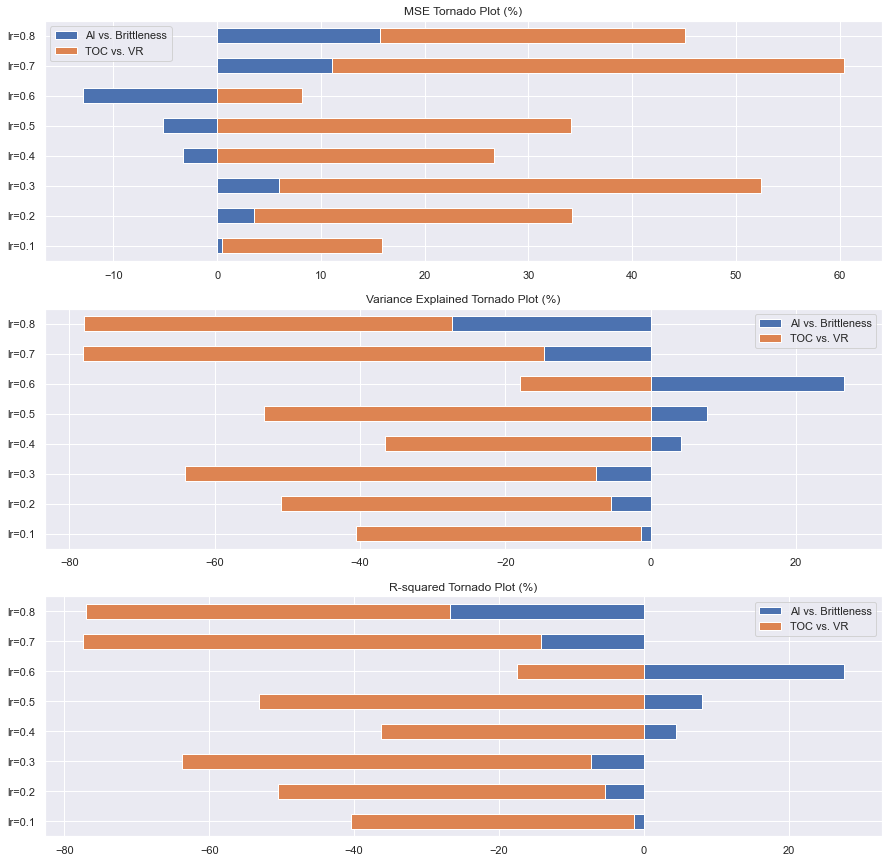

In [7]:
# the following codes are inspired by the Pandas API reference, from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html
index = ['lr=0.1','lr=0.2','lr=0.3','lr=0.4','lr=0.5','lr=0.6','lr=0.7','lr=0.8']    # y-axis of different learning rates
fig, axes = plt.subplots(nrows=3, ncols=1)
combi2_MSE = [(a - b)/b*100 for a, b in zip(MSE_list[1], MSE_list[0])]; combi3_MSE = [(a - b)/b*100 for a, b in zip(MSE_list[2], MSE_list[0])];    # calculate percentage differences
combi2_Var = [(a - b)/b*100 for a, b in zip(Var_list[1], Var_list[0])]; combi3_Var = [(a - b)/b*100 for a, b in zip(Var_list[2], Var_list[0])];    # calculate percentage differences
combi2_Rsq = [(a - b)/b*100 for a, b in zip(Cor_list[1], Cor_list[0])]; combi3_Rsq = [(a - b)/b*100 for a, b in zip(Cor_list[2], Cor_list[0])];    # calculate percentage differences
df_tornado_MSE = pd.DataFrame({'AI vs. Brittleness': combi2_MSE, 'TOC vs. VR': combi3_MSE}, index=index)    # create dataframe to be visualized
df_tornado_Var = pd.DataFrame({'AI vs. Brittleness': combi2_Var, 'TOC vs. VR': combi3_Var}, index=index)    # create dataframe to be visualized
df_tornado_Rsq = pd.DataFrame({'AI vs. Brittleness': combi2_Rsq, 'TOC vs. VR': combi3_Rsq}, index=index)    # create dataframe to be visualized
df_tornado_MSE.plot.barh(stacked=True, figsize=(15,15), ax=axes[0], title = 'MSE Tornado Plot (%)')    # plot the tornado chart
df_tornado_Var.plot.barh(stacked=True, figsize=(15,15), ax=axes[1], title = 'Variance Explained Tornado Plot (%)')    # plot the tornado chart
df_tornado_Rsq.plot.barh(stacked=True, figsize=(15,15), ax=axes[2], title = 'R-squared Tornado Plot (%)')    # plot the tornado chart

Based on the tornado plots of three model performance measures and the comparison between 3 different combinatorics, we can observe some very interesting patterns. It is seen that for combinatorics of TOC and VR, model performs much much worse than the base case. This implies that the relationship of TOC and VR with production is very complex and obscure (or low feature importance). However, at learning rate of $0.6$, the error does not to increase by a lot (only 8%). Furthermore, for combinatorics between AI and Brittleness, the model performs suboptimally at too low/ too high of a learning rate. It performs better than the base case when learning rate is between 0.4~0.6. Therefore, some sort of significance between AI/Brittleness and production is present. Again, with a learning rate of $0.6$, the optimal model performance is achieved. Therefore, the gradient boosting seems to be still robust at medium learning rate, regarding the effects brought by the different combinatorics (this step could be further substantiated with cross-validation/bagging/varying random seed or state to reduce uncertainties in the workflow).

### 3. Define three different loss function metrics, re-do the sensitivity study on learning rates
For now, let's use a fixed combinatorics of dataset (by using Por and LogPerm) and explore the robustness of gradient boosting models through the effects of loss function metrics and varying learning rate. The codes written above are all based on the default loss function of squared error, and let's use the loss function of least absolute deviation and quantile (useful for prediction interval) and try the sensitivity of model performance again. For reference, please visit scikit-learn online documentation on gradient boosting model (https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting).
First, we establish 2 other lists of hyperparameter dictionaries: 

In [8]:
params_all2 = []; params_all3 = []
for lr in lr_all:
    params2 = {
        'loss': 'lad',                                          # least absolute deviation (L1 Norm)
        'max_depth': 5,                                         # maximum depth per tree, fixed
        'learning_rate': lr,                                    # total of 8 lrs
        'criterion': 'mse'                                      # tree construction criteria is mean square error over training
    }
    params3 = {
        'loss': 'quantile',                                     # quantile loss, useful for prediction interval
        'alpha': 0.5,                                           # alpha defines quantile specification, P50 used here
        'max_depth': 5,                                         # maximum depth per tree, fixed
        'learning_rate': lr,                                    # total of 8 lrs
        'criterion': 'mse'                                      # tree construction criteria is mean square error over training
    }
    params_all2.append(params2)
    params_all3.append(params3)

Now, we just repeat the same procedures realized in step 2, as shown below:

<AxesSubplot:title={'center':'R-squared Tornado Plot (%)'}>

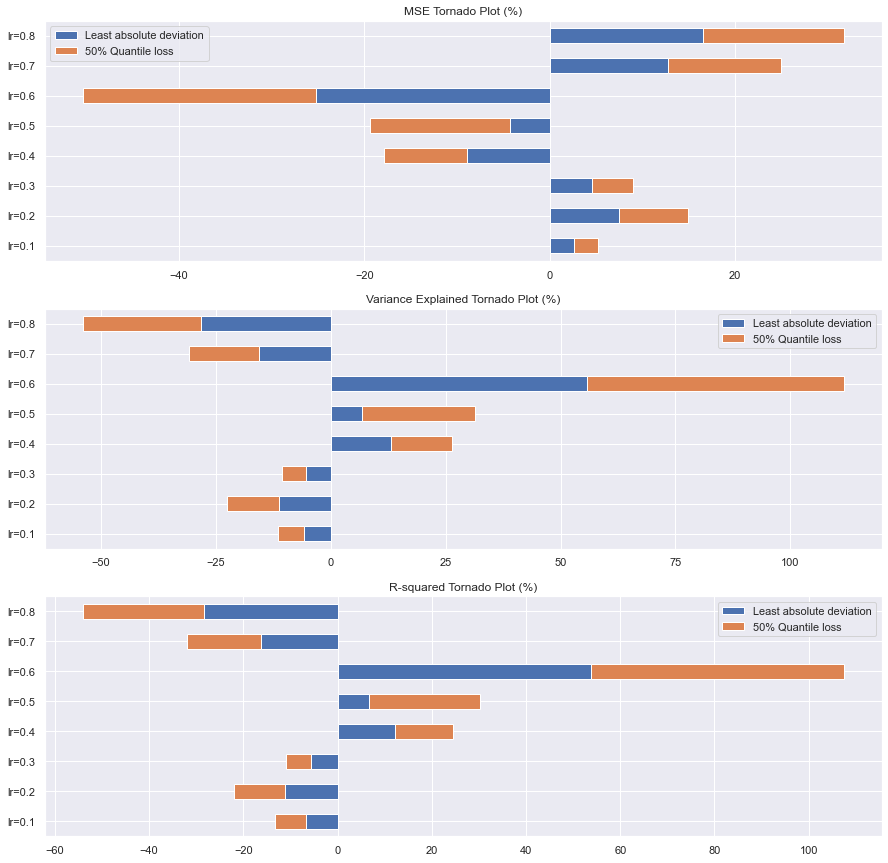

In [9]:
for hypParam in range(0,2):         # a total of two more scenarios of different loss function ('lad' & 'quantile')
    MSE_lr = []; Var_lr = []; Cor_lr = []   # list of model performance of a single lr
    boosting_models = [];        # create new boosting models for each combinatorics
    index = 1                    # index variable to keep track of which lr
    if hypParam == 0:
        for params in params_all2:    # loop over different learning rate
            boosting_models.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params))    # build gradient boosting model
            boosting_models[index-1].fit(X = predictors[0], y = responses[0])                              # fit the model
            index = index + 1    # update lr model index
    if hypParam == 1:
        for params in params_all3:    # loop over different learning rate
            boosting_models.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params))    # build gradient boosting model
            boosting_models[index-1].fit(X = predictors[0], y = responses[0])                              # fit the model
            index = index + 1    # update lr model index
    index = 1                # index variable to keep track of which lr
    for lr in lr_all:        # loop over 8 learning rates
        MSE, Var, Cor = check_model(boosting_models[index-1],my_data_test_subsets[0][predictor_list[0]],my_data_test_subsets[0][predictor_list[1]],my_data_test_subsets[0]["Production"])    # record model performance
        MSE_lr.append(MSE); Var_lr.append(Var); Cor_lr.append(Cor); index = index + 1    # record performance into a list and update lr model index
    MSE_list.append(MSE_lr); Var_list.append(Var_lr); Cor_list.append(Cor_lr);    # append all results
fig, axes = plt.subplots(nrows=3, ncols=1)
loss2_MSE = [(a - b)/b*100 for a, b in zip(MSE_list[3], MSE_list[0])]; loss3_MSE = [(a - b)/b*100 for a, b in zip(MSE_list[4], MSE_list[0])];    # calculate percentage differences
loss2_Var = [(a - b)/b*100 for a, b in zip(Var_list[3], Var_list[0])]; loss3_Var = [(a - b)/b*100 for a, b in zip(Var_list[4], Var_list[0])];    # calculate percentage differences
loss2_Rsq = [(a - b)/b*100 for a, b in zip(Cor_list[3], Cor_list[0])]; loss3_Rsq = [(a - b)/b*100 for a, b in zip(Cor_list[4], Cor_list[0])];    # calculate percentage differences
index = ['lr=0.1','lr=0.2','lr=0.3','lr=0.4','lr=0.5','lr=0.6','lr=0.7','lr=0.8']    # y-axis of different learning rates
df_tornado_MSE = pd.DataFrame({'Least absolute deviation': loss2_MSE, '50% Quantile loss': loss3_MSE}, index=index)    # create dataframe to be visualized
df_tornado_Var = pd.DataFrame({'Least absolute deviation': loss2_Var, '50% Quantile loss': loss3_Var}, index=index)    # create dataframe to be visualized
df_tornado_Cor = pd.DataFrame({'Least absolute deviation': loss2_Rsq, '50% Quantile loss': loss3_Rsq}, index=index)    # create dataframe to be visualized
df_tornado_MSE.plot.barh(stacked=True, figsize=(15,15), ax=axes[0], title = 'MSE Tornado Plot (%)')    # plot the tornado chart
df_tornado_Var.plot.barh(stacked=True, figsize=(15,15), ax=axes[1], title = 'Variance Explained Tornado Plot (%)')    # plot the tornado chart
df_tornado_Cor.plot.barh(stacked=True, figsize=(15,15), ax=axes[2], title = 'R-squared Tornado Plot (%)')    # plot the tornado chart

Based on the tornado plots of three model performance measures and the comparison between 3 different loss functions, we can see some more fascinating results. It is seen that for the loss function using either quantile of 50% threshold or least absolute deviation ($L1 Norm$), model performs much much worse than the base case at either very low or very high learning rate, but performs much much better at the medium magnitude of learning rate (between 0.4 and 0.6). This implies that different loss function can also impact the sensitivity of learning rate on model performance. Again, with a learning rate of $0.6$, the optimal model performance is achieved for the two different loss function. Therefore, the gradient boosting seems to be quite robust at medium learning rate, regarding the effects brought by different loss function (this step could be further substantiated with cross-validation/bagging/varying random seed or state to reduce uncertainties in the workflow).

Let's visualize the actual magnitudes of MSE, variance explained and also R-square score for all the scenarios we analyzed (row $1$: base case; row $2-3$: different combinatorics; row $4-5$: different loss function), by using a heatmap visualization (based on the Stackoverflow public Q&A posts, from https://stackoverflow.com/questions/44971502/what-code-for-a-table-with-colors-instead-of-values)

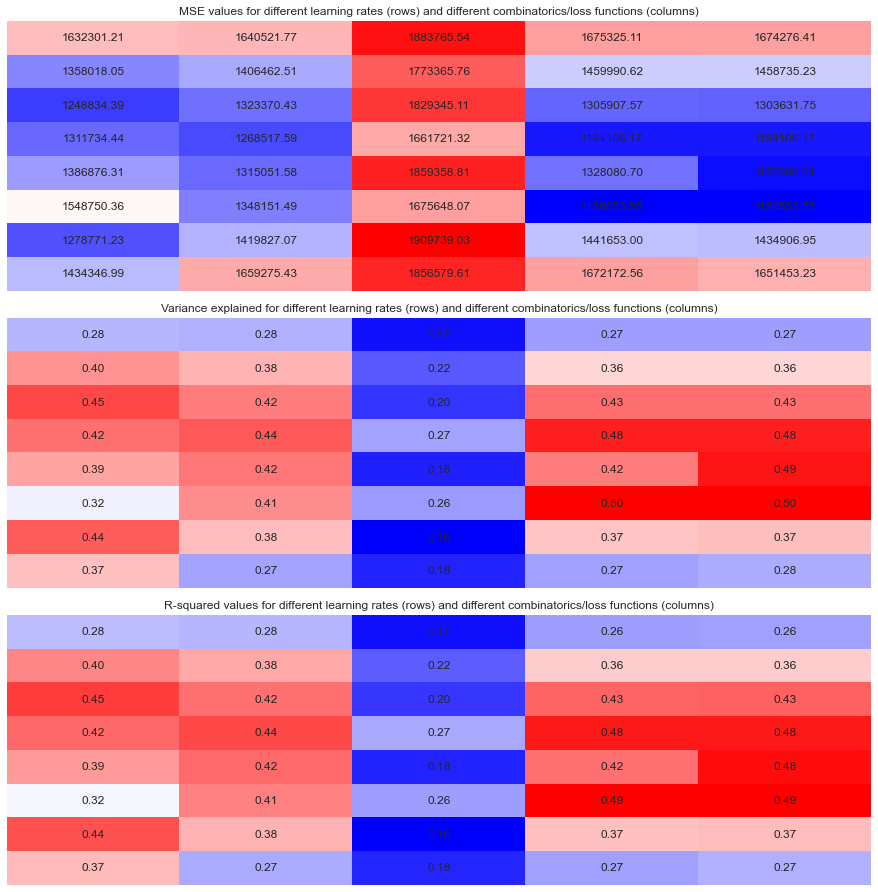

In [10]:
MSE_val = np.array(MSE_list); Var_val = np.array(Var_list); Rsq_val = np.array(Cor_list)    # convert lists to 2D numpy arrays
plt.subplot(311)     # for MSE 
plt.imshow(MSE_val.T, aspect='auto', cmap="bwr")    # plot the heatmap using imshow function
for (i, j), value in np.ndenumerate(MSE_val):        # add the value annotaionts
    plt.text(i, j, "%.2f"%value, va='center', ha='center')    # add the value inside the heatmap
plt.axis('off')
plt.title('MSE values for different learning rates (rows) and different combinatorics/loss functions (columns)');
plt.subplot(312)     # for Variance explained
plt.imshow(Var_val.T, aspect='auto', cmap="bwr")    # plot the heatmap using imshow function
for (i, j), value in np.ndenumerate(Var_val):        # add the value annotaionts
    plt.text(i, j, "%.2f"%value, va='center', ha='center')    # add the value inside the heatmap
plt.axis('off')
plt.title('Variance explained for different learning rates (rows) and different combinatorics/loss functions (columns)');
plt.subplot(313)     # for R-squared score
plt.imshow(Rsq_val.T, aspect='auto', cmap="bwr")    # plot the heatmap using imshow function
for (i, j), value in np.ndenumerate(Rsq_val):        # add the value annotaionts
    plt.text(i, j, "%.2f"%value, va='center', ha='center')    # add the value inside the heatmap
plt.axis('off')
plt.title('R-squared values for different learning rates (rows) and different combinatorics/loss functions (columns)');
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.0, wspace=0.2, hspace=0.10)
plt.show()

As can be seen from the heatmap above, the optimal learning rate for different combinatorics or different loss function can be drastically different. Some of the optimal learning rate is pretty high. Therefore, the impact of learning rate on gradient boosting model robustness is dependent on different problem settings/optimization goals. Nevertheless, extremely fast learning rates will always jeopardize the model performances.

### 4. Observations/Conclusions/Recommendations

* Despite different combinatorics of dataset used for gradient boosting model, either too small of a learning rate or too large of a learning rate will both lead to poor model performance, and there exists an optimal learning rate.

* Generally speaking, gradient boosting model built with predictor features with potentially low feature importance performs worse than those with higher feature importance, for all values of learning rates.

* The use of least absolute deviation, or 50 percent quantile loss function will lead to better performance around medium learning rates, but will deteriorate model performance at either very high or very low learing rates.

There are still many more in-depth studies that could be carried out for analyzing the sensitivity of learning rates on gradient boosting model robustness. The following points provide some recommendations to add to the research.

* Potential extension of this workflow 1: perform uncertainty analysis (such as cross-validation/bagging/changing random seeds&states/etc., and observe the impact of learning rate.

* Potential extension of this workflow 2: execute PCA on the given dataset (relieve the curse of dimensionality), and observe the impact of learning rate.

* Potential extension of this workflow 3: implement this workflow on gradient boosting classification models.


I hope this was helpful,

*Chuxi Liu*

______________________________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
